# Background

- First rotating dataset, first reasonable dataset in awhile, given COVID
- One probe in the magnet, SmarAct placed by hand in center of magnet, 3 probes outside magnet
- NMR not working on new computer
- NMR shipped to Europe for calibration soon...getting data while we can
- After NMR back, need survey done of magnet & SmarAct

# Code

## Imports

In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import math
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
from datetime import datetime
from sys import getsizeof
import re

import operator
from scipy import stats
import scipy.optimize as optimization
import lmfit as lm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
init_notebook_mode(True)

#import seaborn as sns
from wand.image import Image as WImage

from hallprobecalib import hpc_ext_path
#from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo

In [2]:
make_plots = True

In [3]:
hpc_ext_path

'/home/ckampa/data/hallprobecalib_extras/'

In [4]:
plotdir = hpc_ext_path+'plots/hall_probe_rotate/2020-09-09/'

In [5]:
pkl_dir = hpc_ext_path+"datafiles/hall_probe_rotate/"
pkl_file_slow = "hall_rotate.run01.raw.slow.pkl"

In [6]:
df = pd.read_pickle(pkl_dir+pkl_file_slow)

In [7]:
df['seconds_delta'].head(10)

Datetime
2020-09-09 12:43:40     0.0
2020-09-09 12:43:49     9.0
2020-09-09 12:43:58    18.0
2020-09-09 12:44:06    26.0
2020-09-09 12:44:15    35.0
2020-09-09 12:44:24    44.0
2020-09-09 12:44:33    53.0
2020-09-09 12:44:41    61.0
2020-09-09 12:44:50    70.0
2020-09-09 12:44:59    79.0
Name: seconds_delta, dtype: float64

In [8]:
def pplot(fig):
    pio.write_image(fig, 'temp.pdf')
    img = WImage(filename='temp.pdf')
    return img

## Cleaning

In [9]:
directory = "/home/ckampa/Dropbox/LogFiles/"
filename_slow = '2020-09-09 124254.txt'

In [10]:
df = pd.read_csv(directory+filename_slow)
df.columns = df.columns.str.lstrip(" ")
dates = [parser.parse(row.Time) for row in df.itertuples()]# if isdatetime(row.Time.values[0])]
df["Datetime"] = pd.to_datetime(dates)#.astype("str")
df = df.set_index("Datetime")

In [11]:
df.head()

,Time,Magnet Current [V],Magnet Voltage [V],NMR [T],NMR [FFT],DF0000000D5E803A_Raw_X,DF0000000D5E803A_Raw_Y,DF0000000D5E803A_Raw_Z,C90000000D53983A_Raw_X,C90000000D53983A_Raw_Y,...,DF0000000D5E803A_Cal_T,C90000000D53983A_Cal_T,C50000000D5E473A_Cal_T,6A0000000D61333A_Cal_T,SmarAct_Pattern_Angle_1,SmarAct_Pattern_Angle_2,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-09 12:43:40,9/9/2020 12:43:40 PM,240.06108,29.944167,0.0,0.0,-7280.0,56583.0,-8734.0,911.0,1277.0,...,21.371,21.075,21.639,21.878,-5.0,-5.000000,354.999989,-1.0,354.999988,-1.0
2020-09-09 12:43:49,9/9/2020 12:43:49 PM,240.06108,29.944350,0.0,0.0,-7353.0,56621.0,-8800.0,896.0,1437.0,...,21.343,21.068,21.631,21.866,-5.0,-4.949749,355.000006,-1.0,355.050244,-1.0
2020-09-09 12:43:58,9/9/2020 12:43:58 PM,240.06108,29.944567,0.0,0.0,-7335.0,56643.0,-8863.0,766.0,1374.0,...,21.346,21.065,21.619,21.862,-5.0,-4.899498,354.999989,-1.0,355.100492,-1.0
2020-09-09 12:44:06,9/9/2020 12:44:06 PM,240.06108,29.944700,0.0,0.0,-7373.0,56559.0,-8900.0,838.0,1390.0,...,21.338,21.062,21.611,21.854,-5.0,-4.849247,355.000001,-1.0,355.150744,-1.0
2020-09-09 12:44:15,9/9/2020 12:44:15 PM,240.06108,29.944867,0.0,0.0,-7391.0,56692.0,-8841.0,844.0,1397.0,...,21.311,21.055,21.603,21.862,-5.0,-4.798996,354.999997,-1.0,355.201007,-1.0


In [12]:
probes = np.array([])
for col in df.columns:
    #print(df_fast[col].dtype)
    if ("Raw" in col) or ("Cal" in col):#type(df[col].iloc[0]) is np.float64:
        #print(f"{col}")#": mean: {df[col].mean()}")
        probes = np.append(probes, col[:16])
probes = list(np.unique(probes))
print(probes)

['6A0000000D61333A', 'C50000000D5E473A', 'C90000000D53983A', 'DF0000000D5E803A']


In [13]:
probe = probes[0]

In [14]:
probe

'6A0000000D61333A'

In [15]:
for col in df.columns:
    if (type(df[col].iloc[0]) is np.float64) and ('Cal' in col):
        print(f"{col}: mean: {df[col].mean()}")

DF0000000D5E803A_Cal_X: mean: 0.00038687754261421836
DF0000000D5E803A_Cal_Y: mean: 0.005089769879020693
DF0000000D5E803A_Cal_Z: mean: 0.0006230288750256096
C90000000D53983A_Cal_X: mean: 0.00023034007365293994
C90000000D53983A_Cal_Y: mean: -9.824375199754148e-05
C90000000D53983A_Cal_Z: mean: 0.0002117303794304446
C50000000D5E473A_Cal_X: mean: 0.0021403067213685728
C50000000D5E473A_Cal_Y: mean: -0.0016541623496209793
C50000000D5E473A_Cal_Z: mean: 0.008731624893566893
6A0000000D61333A_Cal_X: mean: 0.3164966413083385
6A0000000D61333A_Cal_Y: mean: 0.013938368525097316
6A0000000D61333A_Cal_Z: mean: -0.0029158551863347677
DF0000000D5E803A_Cal_T: mean: 16.639395205900428
C90000000D53983A_Cal_T: mean: 17.075191661544768
C50000000D5E473A_Cal_T: mean: 16.710206822372463
6A0000000D61333A_Cal_T: mean: 17.15259618930547


- Looks like maybe probe "6A0000000D61333A" is in the field

In [16]:
df.columns

Index(['Time', 'Magnet Current [V]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', 'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C90000000D53983A_Raw_X',
       'C90000000D53983A_Raw_Y', 'C90000000D53983A_Raw_Z',
       'C50000000D5E473A_Raw_X', 'C50000000D5E473A_Raw_Y',
       'C50000000D5E473A_Raw_Z', '6A0000000D61333A_Raw_X',
       '6A0000000D61333A_Raw_Y', '6A0000000D61333A_Raw_Z',
       'DF0000000D5E803A_Raw_T', 'C90000000D53983A_Raw_T',
       'C50000000D5E473A_Raw_T', '6A0000000D61333A_Raw_T',
       'DF0000000D5E803A_Cal_X', 'DF0000000D5E803A_Cal_Y',
       'DF0000000D5E803A_Cal_Z', 'C90000000D53983A_Cal_X',
       'C90000000D53983A_Cal_Y', 'C90000000D53983A_Cal_Z',
       'C50000000D5E473A_Cal_X', 'C50000000D5E473A_Cal_Y',
       'C50000000D5E473A_Cal_Z', '6A0000000D61333A_Cal_X',
       '6A0000000D61333A_Cal_Y', '6A0000000D61333A_Cal_Z',
       'DF0000000D5E803A_Cal_T', 'C90000000D53983A_Cal_T',
       'C50000000D5E473A_Cal_T',

### Slow Control Data Cleaning

In [19]:
for probe in probes:
    for t in ["Cal", "Raw"]:
        df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
        #df[f"{probe}_{t}_Res"] = df[f"{probe}_{t}_Bmag"] - df['NMR [T]']
        #df[f"{probe}_{t}_Res_Rel"] = (df[f"{probe}_{t}_Bmag"] - df['NMR [T]']) / df['NMR [T]']

In [23]:
'''
for B in ["X", "Y", "Z"]:
    for probe in probes:
        for t in ["Cal", "Raw"]:
            #df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
            #df[f"{probe}_{t}_{B}_Res"] = df[f"{probe}_{t}_{B}"] - df['NMR [T]']
            #df[f"{probe}_{t}_{B}_Res_Rel"] = (df[f"{probe}_{t}_{B}"] - df['NMR [T]']) / df['NMR [T]']
'''
;

''

In [24]:
df["seconds_delta"] = (df.index - df.index[0]).total_seconds()
df["hours_delta"] = (df.index - df.index[0]).total_seconds()/60**2
df["days_delta"] = (df.index - df.index[0]).total_seconds()/(24*60**2)

In [25]:
for t in ["Cal", "Raw"]:
    for probe in probes:
        df[f"{probe}_{t}_Transverse"] = (df[f"{probe}_Cal_X"]**2+df[f"{probe}_Cal_Y"]**2)**(1/2)
        df[f"{probe}_{t}_Theta"] = np.arccos(df[f"{probe}_Cal_Z"]/df[f"{probe}_Cal_Bmag"])
        df[f"{probe}_{t}_Phi"] = np.arccos(df[f"{probe}_Cal_X"]/df[f"{probe}_Cal_Transverse"])

In [26]:
# raw
for probe in probes:
    df[f"{probe}_Raw_Bmag"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2+df[f"{probe}_Raw_Z"]**2)**(1/2)

for probe in probes:
    df[f"{probe}_Raw_Transverse"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2)**(1/2)
    df[f"{probe}_Raw_Theta"] = np.arccos(df[f"{probe}_Raw_Z"]/df[f"{probe}_Raw_Bmag"])
    df[f"{probe}_Raw_Phi"] = np.arccos(df[f"{probe}_Raw_X"]/df[f"{probe}_Raw_Transverse"])

In [28]:
# NOTE TAKES ~3 MINUTES TO RUN AT THIS POINT (02-03-2020)
if make_plots:
    ## TIME PLOTS
    for col in df.columns:
        fig = scatter2d(df.index, df[col], markers=False, lines=True, show_plot=False) 
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.pdf")
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.png")
    
    ## PLOT HISTOS
    for probe in probes:
        for t in ["Cal", "Raw"]:
            fig = histo(df[f"{probe}_{t}_Bmag"], bins=50, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.pdf")
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.png")

    '''
    ## RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.pdf")
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.png")

    ## REL_RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res_Rel"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.pdf")
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.png")

    ## BMAG RES HISTOS
    for res in ["Res", "Res_Rel"]:
        if res == "Res":
            p = "residuals"
        else:
            p = "relative_residuals"
        for t in ["Cal", "Raw"]:
            for probe in probes:
                #for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{res}"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.pdf")
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.png")
    '''
    
    ## PLOT HISTO ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Cal_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Cal_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLES RAW
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Raw_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.png")

    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Raw_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.png")

In [29]:
df.to_pickle(pkl_dir+pkl_file_slow)

In [30]:
getsizeof(df) / 1000/1000

6.40982

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9148 entries, 2020-09-09 12:43:40 to 2020-09-10 10:51:27
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             9148 non-null   object 
 1   Magnet Current [V]               9148 non-null   float64
 2   Magnet Voltage [V]               9148 non-null   float64
 3   NMR [T]                          9148 non-null   float64
 4   NMR [FFT]                        9148 non-null   float64
 5   DF0000000D5E803A_Raw_X           9148 non-null   float64
 6   DF0000000D5E803A_Raw_Y           9148 non-null   float64
 7   DF0000000D5E803A_Raw_Z           9148 non-null   float64
 8   C90000000D53983A_Raw_X           9148 non-null   float64
 9   C90000000D53983A_Raw_Y           9148 non-null   float64
 10  C90000000D53983A_Raw_Z           9148 non-null   float64
 11  C50000000D5E473A_Raw_X           9148 non-null

## Plotting

In [56]:
fig = scatter2d(2*[df['Time']], [df['SmarAct_Meas_Angle_1'],df['SmarAct_Meas_Angle_2']], inline=False)

In [57]:
len(df)

9148

In [58]:
# pick out part before magnet turned off
df = df[df.index < '2020-09-09 18:55:00']

In [59]:
len(df)

2547

### Gen Plots

In [60]:
df.columns

Index(['Time', 'Magnet Current [V]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', 'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C90000000D53983A_Raw_X',
       'C90000000D53983A_Raw_Y', 'C90000000D53983A_Raw_Z',
       'C50000000D5E473A_Raw_X', 'C50000000D5E473A_Raw_Y',
       'C50000000D5E473A_Raw_Z', '6A0000000D61333A_Raw_X',
       '6A0000000D61333A_Raw_Y', '6A0000000D61333A_Raw_Z',
       'DF0000000D5E803A_Raw_T', 'C90000000D53983A_Raw_T',
       'C50000000D5E473A_Raw_T', '6A0000000D61333A_Raw_T',
       'DF0000000D5E803A_Cal_X', 'DF0000000D5E803A_Cal_Y',
       'DF0000000D5E803A_Cal_Z', 'C90000000D53983A_Cal_X',
       'C90000000D53983A_Cal_Y', 'C90000000D53983A_Cal_Z',
       'C50000000D5E473A_Cal_X', 'C50000000D5E473A_Cal_Y',
       'C50000000D5E473A_Cal_Z', '6A0000000D61333A_Cal_X',
       '6A0000000D61333A_Cal_Y', '6A0000000D61333A_Cal_Z',
       'DF0000000D5E803A_Cal_T', 'C90000000D53983A_Cal_T',
       'C50000000D5E473A_Cal_T',

In [48]:
fig = scatter2d(df['Time'], df[f'{probe}_Cal_Bmag'], inline=False)

In [49]:
fig = scatter2d(df['Time'], df['Magnet Current [V]'], inline=False)

In [61]:
fig = scatter2d(2*[df['Time']], [df[f'{probe}_Cal_Theta'],df[f'{probe}_Cal_Phi']], inline=False)

In [52]:
fig = scatter2d(2*[df['Time']], [df['SmarAct_Meas_Angle_1'],df['SmarAct_Meas_Angle_2']], inline=False)

In [53]:
fig = scatter2d(3*[df['Time']], [df[f'{probe}_Cal_{i}'] for i in ['X','Y','Z']], inline=False)

In [54]:
fig = scatter2d(3*[df['Time']], [df[f'{probe}_Raw_{i}'] for i in ['X','Y','Z']], inline=False)

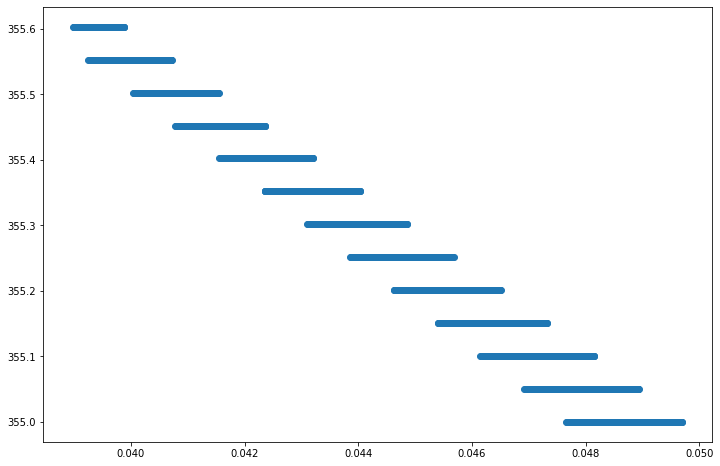

In [62]:
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Phi'], df['SmarAct_Meas_Angle_1'])

In [67]:
df['SmarAct_Meas_Angle_2_pm'] = [i if i <= 180 else i-360 for i in df.SmarAct_Meas_Angle_2]

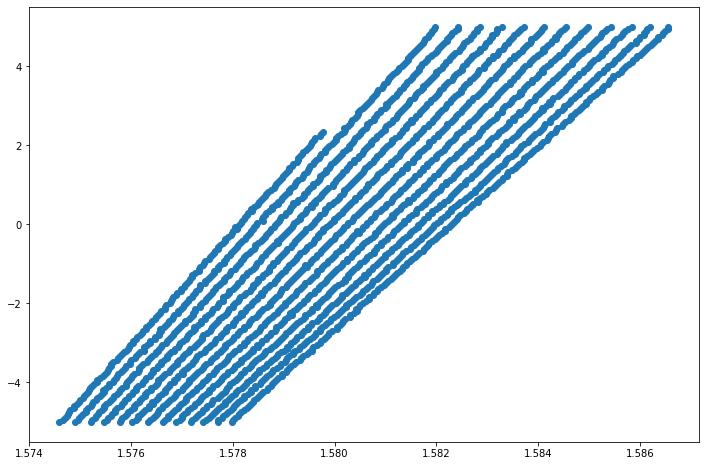

In [68]:
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Theta'], df['SmarAct_Meas_Angle_2_pm'])

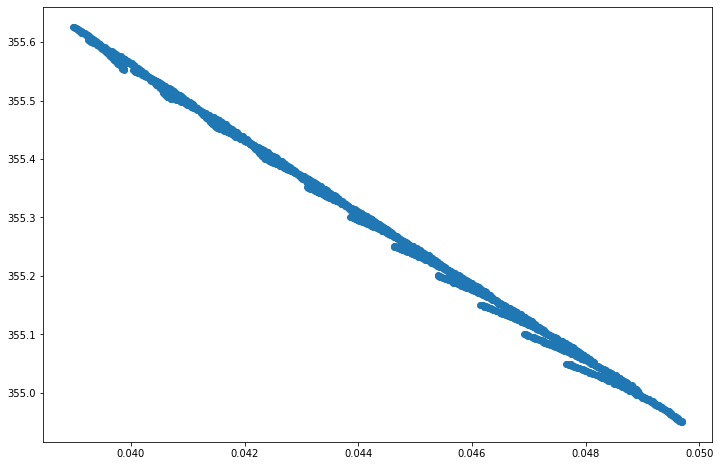

In [85]:
a = 1.00
b = 0.01
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Phi'], a*df['SmarAct_Meas_Angle_1']+b*df['SmarAct_Meas_Angle_2_pm'])

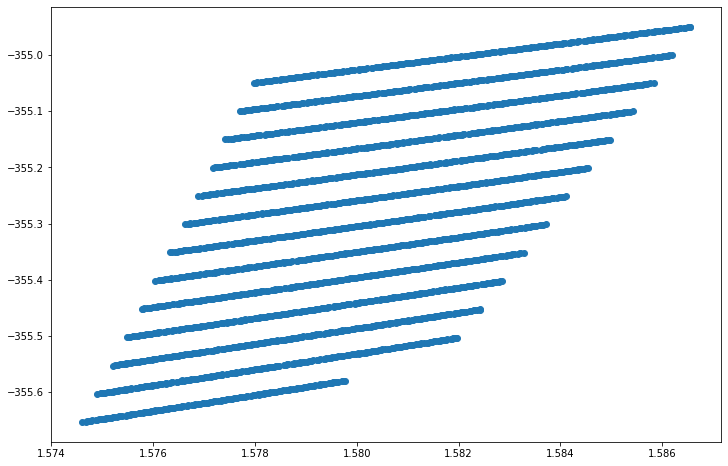

In [105]:
a = -1
b = .01
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Theta'], a*df['SmarAct_Meas_Angle_1']+b*df['SmarAct_Meas_Angle_2_pm'])

## Fitting to find angular relationships (Regression)

### Test 1: Fit individually

In [133]:
df[f'{probe}_Cal_Theta_Deg'] = np.degrees(df[f'{probe}_Cal_Theta'])
df[f'{probe}_Cal_Phi_Deg'] = np.degrees(df[f'{probe}_Cal_Phi'])

In [134]:
def regress_2angle(angle1, angle2, **params):
    return params['m1'] * angle1 + params['m2'] * angle2 + params['b']

In [135]:
model = lm.Model(regress_2angle, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('m1', value=0, vary=True)
params.add('m2', value=0, vary=True)
params.add('b', value=0, vary=True)

In [136]:
#samples = np.concatenate([df['SmarAct_Meas_Angle_1'].values,df['SmarAct_Meas_Angle_2'].values])
result_theta = model.fit(df[f'{probe}_Cal_Theta_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
                         angle2=df['SmarAct_Meas_Angle_2'], params=params)
result_phi = model.fit(df[f'{probe}_Cal_Phi_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
                         angle2=df['SmarAct_Meas_Angle_2'], params=params)

In [138]:
result_theta.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.40614277,0.00716255,(1.76%),0,-inf,inf,True
m2,-6.2571e-04,7.4586e-06,(1.19%),0,-inf,inf,True
b,234.956181,2.54477282,(1.08%),0,-inf,inf,True


In [139]:
result_phi.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.90575413,0.00166454,(0.18%),0,-inf,inf,True
m2,1.3771e-04,1.7333e-06,(1.26%),0,-inf,inf,True
b,324.316462,0.59139204,(0.18%),0,-inf,inf,True


In [140]:
print(result_theta.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 11.3408113
    reduced chi-square = 0.00445787
    Akaike info crit   = -13784.1295
    Bayesian info crit = -13766.6015
[[Variables]]
    m1: -0.40614277 +/- 0.00716255 (1.76%) (init = 0)
    m2: -6.2571e-04 +/- 7.4586e-06 (1.19%) (init = 0)
    b:   234.956181 +/- 2.54477282 (1.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [141]:
print(result_phi.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 0.61248729
    reduced chi-square = 2.4076e-04
    Akaike info crit   = -21217.8926
    Bayesian info crit = -21200.3646
[[Variables]]
    m1: -0.90575413 +/- 0.00166454 (0.18%) (init = 0)
    m2:  1.3771e-04 +/- 1.7333e-06 (1.26%) (init = 0)
    b:   324.316462 +/- 0.59139204 (0.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [142]:
regress_2angle(0, 0, **result_phi.params)

324.31646169106386

In [143]:
a1s = np.linspace(0, 180, 181)
a2s = np.linspace(0, 360, 361)

In [144]:
A1, A2 = np.meshgrid(a1s, a2s)

In [145]:
TH = regress_2angle(A1, A2, **result_theta.params)
PH = regress_2angle(A1, A2, **result_phi.params)

In [150]:
TH.min(), TH.max(), PH.min(), PH.max()

(161.62522598767595, 234.95618101927016, 161.28071895373125, 324.3660383225497)

In [152]:
TH.max()-TH.min(), PH.max()-PH.min()

(73.33095503159421, 163.08531936881843)

-----------

### Test 2: Euler Angles

In [155]:
from scipy.spatial.transform import Rotation

In [504]:
df[f'{probe}_Cal_Theta_Deg'] = np.degrees(df[f'{probe}_Cal_Theta'])
df[f'{probe}_Cal_Phi_Deg'] = np.degrees(df[f'{probe}_Cal_Phi'])
df['SmarAct_Meas_Angle_1_Rad'] = np.radians(df['SmarAct_Meas_Angle_1'])
df['SmarAct_Meas_Angle_2_Rad'] = np.radians(df['SmarAct_Meas_Angle_2'])
#df['SmarAct_Meas_Angle_1_Rad_pm'] =  df['SmarAct_Meas_Angle_1_Rad'] - (df['SmarAct_Meas_Angle_1_Rad'] > np.pi) * 2 * np.pi
df['SmarAct_Meas_Angle_1_Rad_pm'] =  df['SmarAct_Meas_Angle_1_Rad'] - (df['SmarAct_Meas_Angle_1_Rad'] > np.pi) * np.pi
df['SmarAct_Meas_Angle_2_Rad_pm'] = df['SmarAct_Meas_Angle_2_Rad'] - (df['SmarAct_Meas_Angle_2_Rad'] > np.pi) * 2 * np.pi

In [505]:
df['SmarAct_Meas_Angle_2_Rad_pm'].describe()

count    2547.000000
mean       -0.001342
std         0.050262
min        -0.087267
25%        -0.044730
50%        -0.002193
75%         0.040782
max         0.087266
Name: SmarAct_Meas_Angle_2_Rad_pm, dtype: float64

In [506]:
df['SmarAct_Meas_Angle_1_Rad'].describe()

count    2547.000000
mean        6.201072
std         0.003226
min         6.195919
25%         6.198550
50%         6.201181
75%         6.203812
max         6.206444
Name: SmarAct_Meas_Angle_1_Rad, dtype: float64

In [507]:
df['SmarAct_Meas_Angle_1_Rad_pm'], df['SmarAct_Meas_Angle_2_Rad_pm']

(Datetime
 2020-09-09 12:43:40    3.054326
 2020-09-09 12:43:49    3.054326
 2020-09-09 12:43:58    3.054326
 2020-09-09 12:44:06    3.054326
 2020-09-09 12:44:15    3.054326
                          ...   
 2020-09-09 18:54:23    3.064851
 2020-09-09 18:54:32    3.064851
 2020-09-09 18:54:40    3.064851
 2020-09-09 18:54:49    3.064851
 2020-09-09 18:54:58    3.064851
 Name: SmarAct_Meas_Angle_1_Rad_pm, Length: 2547, dtype: float64,
 Datetime
 2020-09-09 12:43:40   -0.087267
 2020-09-09 12:43:49   -0.086390
 2020-09-09 12:43:58   -0.085513
 2020-09-09 12:44:06   -0.084635
 2020-09-09 12:44:15   -0.083758
                          ...   
 2020-09-09 18:54:23    0.037274
 2020-09-09 18:54:32    0.038151
 2020-09-09 18:54:40    0.039028
 2020-09-09 18:54:49    0.039905
 2020-09-09 18:54:58    0.040782
 Name: SmarAct_Meas_Angle_2_Rad_pm, Length: 2547, dtype: float64)

In [508]:
def smaract_to_Bangle(angle1, angle2, **params):
    # 3 euler angles
    sign_cos = np.sign(angle1)
    z = np.cos(angle1)
    x = np.sin(angle1)*np.cos(angle2)
    y = np.sin(angle1)*np.sin(angle2)
    pos = np.array([x,y,z]).reshape(3, -1).T
    #print(pos.shape)
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    pos_rot = rot.apply(pos)
    #print(pos_rot.shape)
    #print((pos == pos_rot).all())
    theta = sign_cos * np.arccos(pos_rot[:,2], np.linalg.norm(pos_rot, axis=1))
    phi = np.arctan2(sign_cos*pos_rot[:,1], sign_cos*pos_rot[:,0])
    return np.concatenate([theta, phi])

In [518]:
thetas, phis = smaract_to_Bangle(df['SmarAct_Meas_Angle_1_Rad_pm'].values, df['SmarAct_Meas_Angle_2_Rad_pm'].values,
                                 **{'e1':0,'e2':-np.pi/2,'e3':np.pi/2}).reshape(2, -1)

In [519]:
thetas, df[f'{probe}_Cal_Theta'].values

(array([1.5632001 , 1.56327628, 1.56335241, ..., 1.57378771, 1.57385491,
        1.57392211]),
 array([1.57797922, 1.57801322, 1.57803424, ..., 1.57970648, 1.57972913,
        1.57976727]))

In [520]:
phis, df[f'{probe}_Cal_Phi'].values

(array([0.08693625, 0.08694256, 0.08694939, ..., 0.07668367, 0.07668124,
        0.07667853]),
 array([0.04969285, 0.0496744 , 0.04968669, ..., 0.03898486, 0.03900463,
        0.03900194]))

In [525]:
(thetas - df[f'{probe}_Cal_Theta']).describe()

count    2547.000000
mean       -0.009539
std         0.002221
min        -0.014779
25%        -0.011175
50%        -0.009522
75%        -0.007879
max        -0.004414
Name: 6A0000000D61333A_Cal_Theta, dtype: float64

In [527]:
(phis - df[f'{probe}_Cal_Phi']).describe()

count    2547.000000
mean        0.037825
std         0.000595
min         0.036578
25%         0.037362
50%         0.037814
75%         0.038262
max         0.039285
Name: 6A0000000D61333A_Cal_Phi, dtype: float64

In [410]:
thetas, df['SmarAct_Meas_Angle_1_Rad_pm'].values

(array([-0.08726665, -0.08726636, -0.08726665, ..., -0.07674188,
        -0.07674209, -0.07674209]),
 array([-0.08726665, -0.08726636, -0.08726665, ..., -0.07674188,
        -0.07674209, -0.07674209]))

In [323]:
np.isclose(thetas, df['SmarAct_Meas_Angle_1_Rad_pm'].values).all()

False

In [324]:
phis, df['SmarAct_Meas_Angle_2_Rad_pm'].values

(array([ 0.08726667,  0.08638954,  0.08551255, ..., -0.03902795,
        -0.03990507, -0.0407822 ]),
 array([-0.08726667, -0.08638954, -0.08551255, ...,  0.03902795,
         0.03990507,  0.0407822 ]))

In [325]:
np.isclose(phis, df['SmarAct_Meas_Angle_2_Rad_pm'].values).all()

False

In [560]:
model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('e1', value=0, vary=False, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('e1', value=np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi/2, vary=True, min=0, max=np.pi)
#params.add('e3', value=np.pi, vary=True, min=0, max=2*np.pi)

In [561]:
samples = np.concatenate([df[f'{probe}_Cal_Theta'].values,df[f'{probe}_Cal_Phi'].values])
result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=df['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)

#result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_2_Rad_pm'].values,
#                   angle2=df['SmarAct_Meas_Angle_1_Rad_pm'].values, params=params)

#result_theta = model.fit(df[f'{probe}_Cal_Theta_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
#                         angle2=df['SmarAct_Meas_Angle_2'], params=params)
#result_phi = model.fit(df[f'{probe}_Cal_Phi_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
#                         angle2=df['SmarAct_Meas_Angle_2'], params=params)

In [562]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
e1,0.00000000,0.00000000,,0,-3.14159265,3.14159265,False
e2,-1.49241613,9.5420e-05,(0.01%),0,-3.14159265,3.14159265,True
e3,0.57474176,0.00116126,(0.20%),0,-3.14159265,3.14159265,True


In [555]:
print(result.fit_report())

[[Model]]
    Model(smaract_to_Bangle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 5094
    # variables        = 2
    chi-square         = 13959.5095
    reduced chi-square = 2.74145905
    Akaike info crit   = 5139.24909
    Bayesian info crit = 5152.32073
[[Variables]]
    e1: -0.39077872 +/- 0.03146595 (8.05%) (init = 0)
    e2: -0.07273196 +/- 0.01361662 (18.72%) (init = 0)
    e3:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1, e2) =  0.309


In [556]:
result.best_fit

array([-0.38343188, -0.3834783 , -0.38352655, ...,  1.85507379,
        1.85715471,  1.85923286])

In [542]:
samples

array([1.57797922, 1.57801322, 1.57803424, ..., 0.03898486, 0.03900463,
       0.03900194])

In [545]:
np.std(samples - result.best_fit)

0.0040455310050301245

In [406]:
df_darren

AttributeError: 'DataFrame' object has no attribute '_data'

In [138]:
result_theta.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.40614277,0.00716255,(1.76%),0,-inf,inf,True
m2,-6.2571e-04,7.4586e-06,(1.19%),0,-inf,inf,True
b,234.956181,2.54477282,(1.08%),0,-inf,inf,True


In [139]:
result_phi.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.90575413,0.00166454,(0.18%),0,-inf,inf,True
m2,1.3771e-04,1.7333e-06,(1.26%),0,-inf,inf,True
b,324.316462,0.59139204,(0.18%),0,-inf,inf,True


In [140]:
print(result_theta.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 11.3408113
    reduced chi-square = 0.00445787
    Akaike info crit   = -13784.1295
    Bayesian info crit = -13766.6015
[[Variables]]
    m1: -0.40614277 +/- 0.00716255 (1.76%) (init = 0)
    m2: -6.2571e-04 +/- 7.4586e-06 (1.19%) (init = 0)
    b:   234.956181 +/- 2.54477282 (1.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [141]:
print(result_phi.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 0.61248729
    reduced chi-square = 2.4076e-04
    Akaike info crit   = -21217.8926
    Bayesian info crit = -21200.3646
[[Variables]]
    m1: -0.90575413 +/- 0.00166454 (0.18%) (init = 0)
    m2:  1.3771e-04 +/- 1.7333e-06 (1.26%) (init = 0)
    b:   324.316462 +/- 0.59139204 (0.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [142]:
regress_2angle(0, 0, **result_phi.params)

324.31646169106386

In [143]:
a1s = np.linspace(0, 180, 181)
a2s = np.linspace(0, 360, 361)

In [144]:
A1, A2 = np.meshgrid(a1s, a2s)

In [145]:
TH = regress_2angle(A1, A2, **result_theta.params)
PH = regress_2angle(A1, A2, **result_phi.params)

In [150]:
TH.min(), TH.max(), PH.min(), PH.max()

(161.62522598767595, 234.95618101927016, 161.28071895373125, 324.3660383225497)

In [152]:
TH.max()-TH.min(), PH.max()-PH.min()

(73.33095503159421, 163.08531936881843)

-------------

In [70]:
r_phi = np.corrcoef(df[f'{probe}_Cal_Phi'], df['SmarAct_Meas_Angle_1'])
r_theta = np.corrcoef(df[f'{probe}_Cal_Theta'], df['SmarAct_Meas_Angle_2_pm'])

In [72]:
r_phi[0,1], r_theta[0,1]

(-0.9852445464472992, 0.8744525524711794)

In [8]:
fig = scatter2d(df[f"{probe}_Cal_T"], df["NMR [T]"], inline=False)

In [9]:
fig = scatter2d(df["Yoke (center magnet)"], df["NMR [T]"], inline=False)

In [10]:
fig = scatter2d( df["NMR [T]"],df["DF0000000D5E803A_Cal_Bmag"], inline=False)

In [15]:
fig = scatter2d( df["DF0000000D5E803A_Cal_T"],(df["DF0000000D5E803A_Cal_X"]-df["NMR [T]"])/df["NMR [T]"], markers=True, lines=False, inline=False)

In [30]:
df.tail(1)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,DF0000000D5E803A_Cal_Phi,6A0000000D61333A_Raw_Transverse,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-12 11:30:27,2/12/2020 11:30:27 AM,240.0706,28.651067,32.329288,30.131769,8.32542,10.983446,13.566287,14.512237,22.224464,...,1.56294,539.726783,0.128991,0.757882,59928.373313,1.254132,1.244276,3.387744e+06,1.56076,1.113235


In [31]:
len(df)

23019

In [32]:
len(df) * 50 / 60 / 60 / 24

13.321180555555555

In [33]:
fig = histo(df["NMR [T]"], bins=50, inline=False)

In [34]:
fig = scatter2d(3*[df.index], [df[col+"_Cal_Bmag"] for col in probes], inline=False);

In [35]:
fig = scatter2d(2*[df.index], [df["NMR [T]"], df[f"{probe}_Cal_Bmag"]], show_plot=False);

In [36]:
plot(fig)

'temp-plot.html'

In [37]:
fig = scatter2d(df.index, df[f"{probe}_Cal_Res_Rel"], show_plot=False);

In [38]:
plot(fig)

'temp-plot.html'

In [39]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

In [40]:
fig = scatter2d(df["Roof"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

~ -2e-4 change in residual after changing temperature (+7 deg C).

**(old, early Run06)**
~ -5e-5 change in residual after changing temperature (+4 deg C).

In [41]:
fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=75, show_plot=False);
plot(fig)
#fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=50, yscale='log')

'temp-plot.html'

In [42]:
df["day"] = df.index.day

In [43]:
fig = px.histogram(df, x=f"{probe}_Cal_Res_Rel", color="day")

In [44]:
fig.update_layout(
    autosize=False,
    width=1800,
    height=800
    #margin=dict(l=20, r=20, t=20, b=20),
    #padding=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="LightSteelBlue",
);

In [45]:
#fig.show()

In [46]:
plot(fig)

'temp-plot.html'

### Temps

In [47]:
temps_ch = [a for a in df.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append("Hall Element")
temps_ch.append("Floor")
temps_ch.append("Roof")
temps_ch.append("Yoke")
temps_ch.append("Yoke (center magnet)")
temps_ch.append(f"{probe}_Cal_T")

In [48]:
#temps_ch

In [49]:
fig = scatter2d([df.index for c in temps_ch],[df[c] for c in temps_ch],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]";

In [50]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_full'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_full.html'

In [51]:
plot(fig)

'temp-plot.html'

In [56]:
temps_water = [col for col in df.columns if ("ICW" in col) or ("LCW" in col)]

In [105]:
#temps_water

In [57]:
fig = scatter2d([df.index for c in temps_water],[df[c] for c in temps_water],inline=True, show_plot=False);
fig.layout.title = "Water Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"

In [58]:
#fig.show()
plot(fig)

'temp-plot.html'

In [59]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_water'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_water.html'

In [60]:
temps_ambient = [col for col in df.columns if ("Ambient" in col)]
#temps_ambient

In [61]:
fig = scatter2d([df.index for c in temps_ambient],[df[c] for c in temps_ambient],inline=True, show_plot=False);
fig.layout.title = "Ambient Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [62]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_ambient'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_ambient.html'

In [63]:
temps_magnet = [col for col in df.columns if (("PS" in col) or ("Coil" in col) or ("Yoke" in col)) and ("Orange" not in col)]
#temps_magnet

In [64]:
fig = scatter2d([df.index for c in temps_magnet],[df[c] for c in temps_magnet],inline=True, show_plot=False);
fig.layout.title = "Magnet Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [65]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_magnet'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_magnet.html'

## Seeing Temperature Corrections

In [66]:
fig = scatter2d(df[f"{probe}_Cal_T"], df["NMR [T]"], df.days_delta, show_plot=False)

In [67]:
plot(fig)

'temp-plot.html'

In [68]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [69]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [70]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"], df.days_delta, inline=False)

In [71]:
fig = scatter2d(3*[df[f"{probe}_Cal_T"]], [df[f"{probe}_Raw_{comp}"] / df["NMR [T]"] for comp in ["X","Y","Z"]],
                3*[df.days_delta], inline=False)

In [72]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Theta"], df.days_delta, inline=False)

In [73]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Phi"], df.days_delta, inline=False)

### Fit!

In [52]:
df = df[df["NMR [T]"] != 0]

In [53]:
def volt(temp, A, B):
    return A * temp + B

In [54]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [55]:
x_dat = df[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [56]:
params, cov = optimization.curve_fit(volt, x_dat, df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [57]:
params, cov

(array([-1.18040565e+03,  2.83879530e+06]), array([[ 0.04191652, -0.88642618],
        [-0.88642618, 19.31005472]]))

In [58]:
np.sqrt(cov[0,0])

0.20473523980511196

In [59]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

-0.985276720331901

Parameters have strong correlation

In [60]:
A_fit, B_fit = params

In [61]:
df["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [84]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[f"{probe}_Cal_T"], y=df["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
plot(fig)

'temp-plot.html'

In [85]:
fig.update_traces(marker=dict(size=5));
plot(fig);

Bmag fit looks pretty good so far (4 data points).

## Aggregate data

In [86]:
#df["Floor"].diff(5).rolling(5).mean().head()

In [62]:
#fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)
fig = scatter2d(2*[df.index], [df["Floor"],df["Floor"].diff(5).rolling(5).mean()], inline=False)

In [63]:
#stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.008) #| (np.isnan(df["Floor"].diff(5)))
stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.025) #| (np.isnan(df["Floor"].diff(5)))

In [64]:
df_ = df[stable_temp]

In [65]:
len(df), len(df_)

(23019, 22119)

In [66]:
df_.tail(2)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi,day,Bmag_lsq
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-12 10:43:26,2/12/2020 10:43:26 AM,240.070883,28.632033,31.722984,29.564817,8.06336,10.695252,13.167009,14.173713,21.753210,...,0.130385,0.723302,59932.263006,1.252390,1.245125,3.391588e+06,1.562459,1.113487,12,2.809498e+06
2020-02-12 10:44:26,2/12/2020 10:44:26 AM,240.070940,28.632233,31.783482,29.606745,8.10455,10.739941,13.157190,14.219605,21.770008,...,0.117138,0.893853,59994.372544,1.252968,1.244613,3.391355e+06,1.562461,1.113479,12,2.809295e+06


In [67]:
fig = scatter2d(df[stable_temp][f"{probe}_Cal_T"],
                df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"],
                df[stable_temp].days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[stable_temp][f"{probe}_Cal_T"], y=df[stable_temp]["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=5));
plot(fig);

In [68]:
phi0 = df_.iloc[0][f"{probe}_Raw_Phi"]
theta0 = df_.iloc[0][f"{probe}_Raw_Theta"]

In [69]:
df_["ANGLE"] = np.sqrt((df_[f"{probe}_Raw_Theta"]-theta0)**2 + (df_[f"{probe}_Raw_Phi"]-phi0)**2)

In [70]:
fig = scatter2d(df_["ANGLE"], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [71]:
fig = scatter2d(df_[f'{probe}_Raw_Theta'], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [64]:
## NEW, do all at once

In [72]:
df_["Scaled Hall Voltage"] = df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall X"] = df_[f"{probe}_Raw_X"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Y"] = df_[f"{probe}_Raw_Y"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Z"] = df_[f"{probe}_Raw_Z"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]

In [90]:
w = 0.3
ts = np.array([15.9, 17.7, 19.3, 21.2, 22.75, 24.58, 26.1])#16.0,16.8,18.6,20.3,22.0,23.8,25.35,27.0,28.0])
ts_h = ts + w
ts_l = ts - w

In [91]:
ts_l

array([15.6 , 17.4 , 19.  , 20.9 , 22.45, 24.28, 25.8 ])

In [92]:
ts_h

array([16.2 , 18.  , 19.6 , 21.5 , 23.05, 24.88, 26.4 ])

In [93]:
maps = [((df_[f"{probe}_Cal_T"] > ts_l[i]) & (df_[f"{probe}_Cal_T"] < ts_h[i])) for i in range(len(ts))]

In [94]:
len(maps)

7

In [95]:
map_full = maps[0]

for m in maps[1:]:
    map_full = map_full | m
    

In [96]:
len(df_[map_full])

22113

In [97]:
len(df_)

22119

In [98]:
xs = np.zeros_like(ts)
ys = np.zeros_like(ts)
xerrs = np.zeros_like(ts)
yerrs = np.zeros_like(ts)
ns = np.zeros_like(ts)

## calculate averages
for i,m in enumerate(maps):
    df_sp = df_[m]
    ns[i] = len(df_sp)
    xs[i] = df_sp[f"{probe}_Cal_T"].mean()
    xerrs[i] = df_sp[f"{probe}_Cal_T"].std()
    ys[i] = df_sp["Scaled Hall Voltage"].mean()
    yerrs[i] = df_sp["Scaled Hall Voltage"].std()

In [99]:
xs

array([15.89655233, 17.64736637, 19.34827515, 21.13672514, 22.81150658,
       24.53801517, 26.19842398])

In [100]:
def volt(temp, A, B):
    return A * temp + B

In [101]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [102]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [103]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [104]:
params, cov = optimization.curve_fit(volt, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [105]:
# stable temp
params, cov

(array([-1.42562616e+03,  3.42826666e+06]), array([[ 0.06097712, -1.28812275],
        [-1.28812275, 28.03706027]]))

In [106]:
# stable temp averaged
params_avg, cov_avg

(array([-1.42392463e+03,  3.42821889e+06]),
 array([[   270.72168011,  -5707.46638385],
        [ -5707.46638385, 123529.7055177 ]]))

In [107]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [108]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)
df_["Bmag_lsq_avg"] = volt(x_dat, A_fit_avg, B_fit_avg)

In [109]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [110]:
B_lsq = volt(ts, A_fit, B_fit)
B_lsq_avg = volt(ts, A_fit_avg, B_fit_avg)

In [111]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [112]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature"

plot(fig, filename=filename+'.html')

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/scaled_voltage_vs_temperature.html'

In [113]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probe}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Cal_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df["NMR [T]"],
                df[f"{probe}_Raw_Bmag"],# * df[f"{probe}_Cal_T"].min() / df[f"{probe}_Cal_T"],
                df.days_delta, opacity=1., inline=False)

In [ ]:
x = np.array([6e-4, 2.36e-2, 1.2492]) # B in Tesla
y = np.array([4.85e3, 6.43e4, 3.5e6]) # Hall voltage (Bmag), note: 3 different probes

In [ ]:
fig = scatter2d(x, y, lines=False, markers=True, size_list=[8], inline=False)

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([3e6, 0.]) # A, B

In [ ]:
x_dat = x
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = y

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
#A_fit_avg, B_fit_avg = params_avg

In [ ]:
B_lsq_dat = volt_b(x_dat, A_fit, B_fit)
#df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                lines=False, markers=True,
                size_list=[8], opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

#fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

Nice! Looks surprisingly linear for 3 different probes.

In [ ]:
dof = 3 - 2

In [ ]:
### pick std = 55
std_volt = 50.#500.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
#fit_chi2 = chi2(B_lsq, y_dat, std_volt)
fit_chi2 = chi2(B_lsq_dat, y_dat, std_volt)
fit_chi2

In [ ]:
dof = len(x_dat) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
P.max()

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., 1.0], 'r--');

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([1e11, 0.]) # A, B

In [ ]:
x_dat = df_["NMR [T]"]
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_[f"{probe}_Raw_Bmag"] / (-1.21e03*df_[f"{probe}_Cal_T"])# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

In [114]:
### pick std = 55
std_volt = 50.#51.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
ys_fit = volt(xs, A_fit_avg, B_fit_avg)

In [ ]:
fit_avg_chi2 = chi2(ys_fit, ys, yerrs)
fit_avg_chi2

In [ ]:
dof = len(xs) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_avg_chi2, fit_avg_chi2],[0., P.max()], 'r--');

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
std_volt = 75.

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,30000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Investigate Noise

In [ ]:
t = df_.index

In [ ]:
V = df_[f"{probe}_Raw_Z"]

In [ ]:
V_mean = V.rolling(window=75).mean() # w interval = 50 s, should be ~72 for one hour average

In [ ]:
#fig = scatter2d(2*[t], [V, V_mean], inline=False)

In [ ]:
diff = V - V_mean

In [ ]:
#fig = histo(diff, bins=50, inline=False)

In [ ]:
g = np.absolute(diff) < 200.

In [ ]:
diff[g].std()

In [ ]:
fig = histo(diff[g], bins=75, inline=False)

Component Standard Deviation:
- x: 54.9
- y: 60.5
- z: 58.47

In [119]:
sig_x = 54.9
sig_y = 60.5
sig_z = 58.5

In [120]:
# assuming no covariance
sigma_B = np.sqrt(df_[f"{probe}_Raw_X"]**2*sig_x**2 + \
                  df_[f"{probe}_Raw_Y"]**2*sig_y**2 + \
                  df_[f"{probe}_Raw_Z"]**2*sig_z**2) / df_[f"{probe}_Raw_Bmag"]

In [121]:
sigma_B.name = "sigma_B"

In [ ]:
fig = histo(sigma_B, bins=75, inline=False)

In [ ]:
fig = scatter2d(t, sigma_B, inline=False)

In [ ]:
sigma_B.describe()

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

Try adding a few more polynomial terms

In [ ]:
def volt_3rd(temp, A, B, C, D):
    #return A * temp + B * temp**2 + C * temp**3 + D
    return A * temp + B * temp**2 + D

In [ ]:
guess = np.array([-1300 / 3.5, 0, 0, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [ ]:
params, cov = optimization.curve_fit(volt_3rd, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt_3rd, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
# stable temp averaged
params_avg, cov_avg

In [ ]:
A_fit, B_fit, C_fit, D_fit = params
A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

plot(fig, filename=filename+'.html')

In [ ]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 3#4 # 4 parameter fit
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
# 4th order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
for probe in probes:
    fig = scatter2d(df_.index, df_[f"{probe}_Raw_Bmag"], inline=False)

## Fit Routine
**IMPORTANT**
- should add this as a tool in hallprobecalib

In [ ]:
## FIT ORDER N

In [ ]:
#import lmfit as lm

In [115]:
def polyfit_order_n(N, x_dat, y_dat, std_dat):
    # e.g. order 1 gives form y = C0 + C1*x
    # returns lmfit result object
    Cs = {}
    
    def polynomial(x, N, **Cs):
        ys = np.zeros_like(x)
        for n in range(N+1):
            C = Cs[f'C_{n}']
            ys += C * x**n
        return ys
    
    # using lmfit
    model = lm.Model(polynomial, independent_vars=['x'])
    params = lm.Parameters()
    params.add('N', value=N, vary=False) # just telling us when to truncate our sum
    for n in range(N+1):
        params.add(f'C_{n}', value=0)
    
    result = model.fit(y_dat.values, x=x_dat.values, params=params, weights=1/std_dat)
    
    print(result.fit_report())
   
    return result

In [116]:
result = polyfit_order_n(1, df_[f"{probe}_Cal_Bmag"], df_["NMR [T]"], 2e-5*np.ones_like(df_["NMR [T]"]))

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 22119
    # variables        = 2
    chi-square         = 27081.2107
    reduced chi-square = 1.22445226
    Akaike info crit   = 4480.95607
    Bayesian info crit = 4496.96446
[[Variables]]
    N:    1 (fixed)
    C_0:  0.25557552 +/- 5.7260e-04 (0.22%) (init = 0)
    C_1:  0.78821941 +/- 4.7417e-04 (0.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_0, C_1) = -1.000



(<Figure size 864x864 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

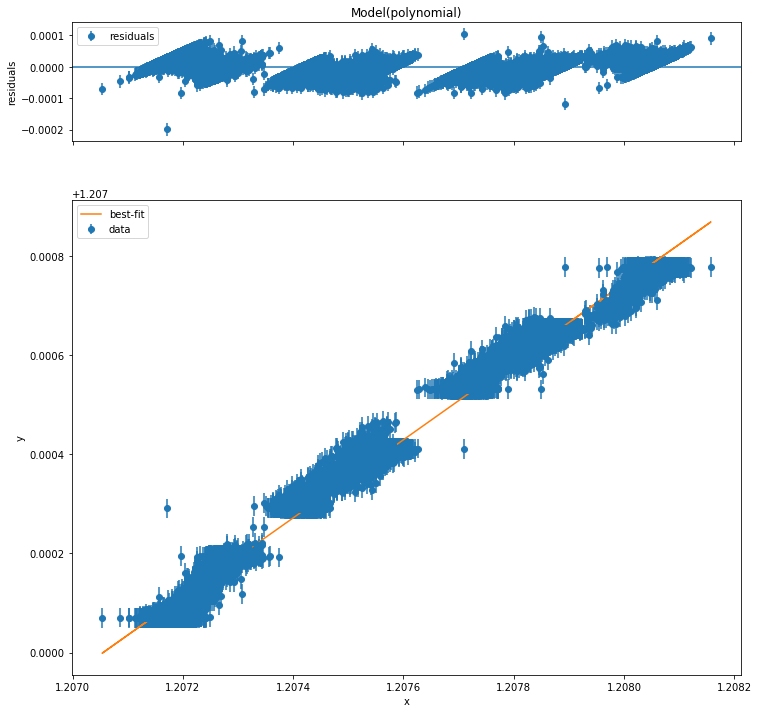

In [117]:
result.plot()

In [132]:
result = polyfit_order_n(8, df_[f"{probe}_Cal_T"], df_["Scaled Hall Voltage"], sigma_B)

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 332
    # data points      = 22119
    # variables        = 9
    chi-square         = 20418.5485
    reduced chi-square = 0.92349835
    Akaike info crit   = -1751.37042
    Bayesian info crit = -1679.33269
[[Variables]]
    N:    8 (fixed)
    C_0: -50834504.7 +/- 1055699.27 (2.08%) (init = 0)
    C_1:  15620950.6 +/- 308635.070 (1.98%) (init = 0)
    C_2: -1738019.29 +/- 34917.8528 (2.01%) (init = 0)
    C_3:  82236.4627 +/- 1684.54182 (2.05%) (init = 0)
    C_4:  26.1596018 +/- 2.07267659 (7.92%) (init = 0)
    C_5: -183.901018 +/- 3.88018188 (2.11%) (init = 0)
    C_6:  8.55395175 +/- 0.18457209 (2.16%) (init = 0)
    C_7: -0.16987719 +/- 0.00374814 (2.21%) (init = 0)
    C_8:  0.00130542 +/- 2.9475e-05 (2.26%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_3, C_7) = -1.001
    C(C_1, C_5) = -1.001
    C(C_3, C_6) =  1.001
    C(C_2, C_5) =  1.001

(<Figure size 864x864 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

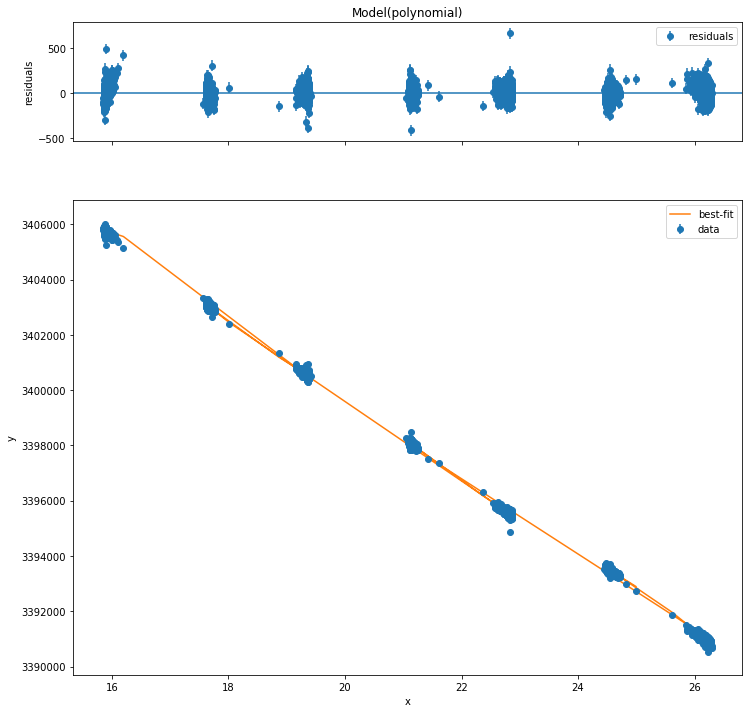

In [133]:
result.plot()

In [169]:
ns

array([35398.,  1270.,  4974.,  1439.,  1403.,  1430.,   204.,  1224.,
        2142.])

In [170]:
ns / ns.mean()

array([6.438081  , 0.23098375, 0.90465605, 0.26172096, 0.25517339,
       0.26008407, 0.0371029 , 0.22261741, 0.38958047])

In [ ]:
x_dat_avg = pd.Series(x_dat_avg)
ys = pd.Series(ys)
yerrs = pd.Series(yerrs)
ns = pd.Series(ns)

In [ ]:
result = polyfit_order_n(1,x_dat_avg, ys, ns.mean()*yerrs / ns)

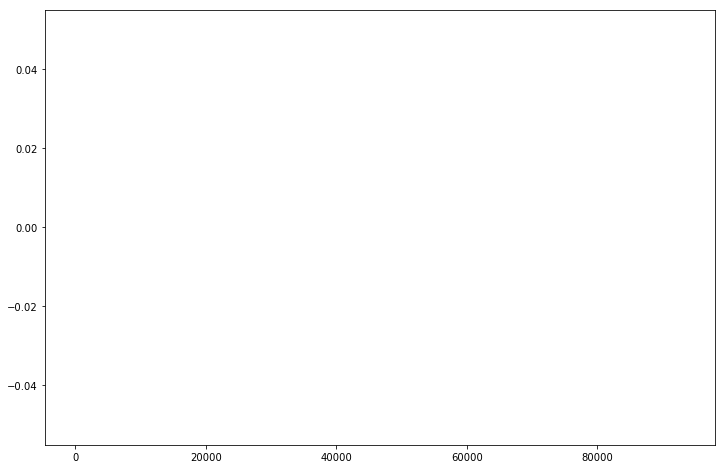

In [171]:
#def chi2(f, x, std):
#        return np.sum(np.square((x-f)/std))

#len(sigma_B)

#len(df_)

#fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
#fit_chi2
fit_chi2 = result.chisqr#0.3247

dof = len(df_) - 5#4 # 4 parameter fit
#dof

n = np.linspace(0,12, 100)

P = stats.chi2.pdf(n, dof)

# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
fig = scatter2d(df_.index, df_["DF0000000D5E803A_Cal_Res_Rel"], df_.days_delta, inline=False)

In [ ]:
result.plot()

In [172]:
def plot_polynomial(N, x_dat, y_dat, c_dat, result,
                    size=5, filename=None, inline=False, show_plot=True):
    
    ####averaged=True

    # plot the data
    fig = scatter2d(x_dat,
                    y_dat,
                    c_dat, opacity=0.9, show_plot=False)
    # add line for fit
    xs = np.linspace(x_dat.min(), x_dat.max(), 100)
    ys = result.eval(x=xs)
    fig.add_trace(go.Scatter(
                        x=xs, y=ys,
                        mode='lines', name=f'Order {N} Polynomial fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=size));

    '''if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))'''

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = "
    for n in range(N+1):
        p = result.params[f"C_{n}"]
        eqn += f"{p:.2E} * x^{n}"
        if (n >= 2) and ((n+1)%3 == 0) and (n != N):
            eqn += "<br>    "
    ax = 250
    ay = -25
    if result.params["C_1"] < 0:
        i = 20
        #ax= +
        #ay= -
    else:
        i = -20
        ax = -ax
        ay = -ay
    fig.add_annotation(
        go.layout.Annotation(
                x=xs[i],
                y=ys[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=12,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=ax,
                ay=ax,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.65,
                showarrow=True#False
        )
    )

    fig.update_layout(title="y vs. x")
    fig.update_xaxes(title_text='x')
    fig.update_yaxes(title_text='y')
    #fig.update_layout( width=1000,height=600,)

    #filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [173]:
fig = plot_poly_chi2(4, result)

NameError: name 'plot_poly_chi2' is not defined

In [ ]:
fig = plot_poly_chi2(1, result)

In [ ]:
N = 1
len(result.data) - (N+1) # y values

In [174]:
def plot_poly_chi2(N, result, filename=None, inline=False, show_plot=True):
    dof = len(result.data) - (N+1)
    fit_chi2 = result.chisqr
    P_at_fit = 1.-stats.chi2.cdf(fit_chi2, dof)
    print(f"Probability of Chi2: {P_at_fit}")
    
    lo = min(fit_chi2*0.5, dof / 4)
    hi = max(fit_chi2*1.5, 2*dof*1.5)
    
    n = np.linspace(lo,hi, 1000)

    P = stats.chi2.pdf(n, dof)
    
    n = pd.Series(n, name="Chi^2")
    P = pd.Series(P, name="p.d.f.")
    
    if np.isfinite(P.max()):
        ymax = P.max()
    else:
        ymax = 1.

    fig = scatter2d(n,P, show_plot=False)
    fig.add_trace(go.Scatter(
                            x=[fit_chi2, fit_chi2], y=[0., ymax],
                            mode='lines', name=f'Fit Chi^2 = {fit_chi2}',#"|V|/|B| = A * Temp. + B",
                            line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                      width=1,
                                      dash='dash')));
        
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [175]:
fig = plot_poly_chi2(4, result)

Probability of Chi2: 0.0


In [ ]:
len(result.data)

In [ ]:
len(result.params) - 2

In [ ]:
result.chisqr

In [ ]:
result.

In [ ]:
result.eval(x=df[f"{probe}_Cal_T"])

In [ ]:
polynomial(np.array([0,1,2]), len(result.params)-2, **result.params)

In [ ]:
    df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
    df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    ts = np.linspace(x_dat.min(), x_dat.max(), 25)

    B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
    B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
    B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

    averaged=True

    fig = scatter2d(x_dat,
                    y_dat,
                    df_.days_delta, opacity=0.8, show_plot=False)

    fig.add_trace(go.Scatter(
                        x=ts, y=B_lsq,
                        mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=1));

    if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

    i = 6
    fig.add_annotation(
        go.layout.Annotation(
                x=ts[i],
                y=B_lsq.iloc[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=14,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=+250,
                ay=-25,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.7,
                showarrow=True#False
        )
    )

    fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
    fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
    fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
    fig.update_layout( width=1000,height=600,)

    filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

    plot(fig, filename=filename+'.html')

    pio.write_image(fig, filename+".pdf")
    pio.write_image(fig, filename+".png")



    def chi2(f, x, std):
        return np.sum(np.square((x-f)/std))

    len(sigma_B)

    len(df_)

    fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
    fit_chi2

    dof = len(df_) - 3#4 # 4 parameter fit
    dof

    n = np.linspace(1000,20000, 1000)

    P = stats.chi2.pdf(n, dof)

    # 3rd order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

    # 4th order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

## OLD

In [ ]:
high_point = (df[f"{probe}_Cal_T"] > 20) & (df[f"{probe}_Cal_T"] < 21)
low_point = (df[f"{probe}_Cal_T"] > 16) & (df[f"{probe}_Cal_T"] < 17)
mid_point = (df[f"{probe}_Cal_T"] > 18) & (df[f"{probe}_Cal_T"] < 19)
h = high_point & stable_temp
l = low_point & stable_temp
m = mid_point & stable_temp

In [ ]:
plt.hist(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=50);

In [ ]:
fig = scatter2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"],
                df[h].days_delta, inline=False)

In [ ]:
hist2 = plt.hist2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=35);

In [ ]:
hist2[1]

In [ ]:
36*36

In [ ]:
len(hist2[1])

In [ ]:
len(hist2[2])

In [ ]:
int(np.floor(hist2[0].argmax() / 36))

In [ ]:
int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))

In [ ]:
1296-int(np.floor(hist2[0].argmax() / 36))*36

In [ ]:
hist2[0][int(np.floor(hist2[0].argmax() / 35)), int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))]

In [ ]:
for x, y in np.argwhere(hist2[0] == hist2[0].max()):
    # center is between x and x+1
    print(np.average(hist2[1][x:x + 2]), np.average(hist2[2][y:y + 2]))

In [ ]:
(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).describe()

In [ ]:
df[h][f"{probe}_Cal_T"].describe()

In [ ]:
fig = scatter2d(df[stable_temp].index, df[stable_temp]["Floor"], inline=False)

In [ ]:
fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)

In [ ]:
df["Roof"].diff(4).plot()

In [ ]:
df["NMR [T]"].plot()
#df["Roof"].diff(1).plot();

In [ ]:
df_ = df[l|m|h]

In [ ]:
def volt(temp, A, B):
    return A * temp + B

In [ ]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt, x_dat, df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# Bmag ### STABLE TEMP
params, cov

In [ ]:
np.sqrt(cov[0,0])

In [ ]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

Parameters have strong correlation

In [ ]:
A_fit, B_fit = params

In [ ]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [ ]:
p_low = [df[l][f"{probe}_Cal_T"].mean(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).mean()]
p_high = [df[h][f"{probe}_Cal_T"].mean(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).mean()]
p_mid = [df[m][f"{probe}_Cal_T"].mean(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).mean()]

In [ ]:
std_low = [df[l][f"{probe}_Cal_T"].std(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).std()]
std_high = [df[h][f"{probe}_Cal_T"].std(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).std()]
std_mid = [df[m][f"{probe}_Cal_T"].std(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).std()]

In [ ]:
std_low

In [ ]:
fig = scatter2d(df_[f"{probe}_Cal_T"],
                df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"],
                df_.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq"],
                    mode='lines', name="|V|/|B| = A * Temp. + B",
                    line=dict(color='deeppink', width=1,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=1));
#plot(fig);

fig.add_trace(go.Scatter(
    x= [p_low[0],p_mid[0],p_high[0]],
    y=[p_low[1],p_mid[1],p_high[1]],
    mode='markers',
    name='averaged_data',
    error_x=dict(
        type='data',
        array=[std_low[0], std_mid[0], std_high[0]],
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=[std_low[1], std_mid[1], std_high[1]],
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=4,
        color="Red",
    )
))

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1200,height=900,)

#fig = go.Figure(traces)
plot(fig, filename=plotdir+"temp_fit_2point_aggregate.html")

In [ ]:
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.pdf")
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.png")

In [ ]:
std_low

In [ ]:
std_mid

In [ ]:
std_high

In [ ]:
### pick std = 55
std_volt = 45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_[f"{probe}_Raw_Bmag"]/df_["NMR [T]"], std_volt)
fit_chi2

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
stats.chi2.pdf(6300, 6325)

In [ ]:
n = np.linspace(0, 7000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Magnet Behavior

In [ ]:
probes

In [ ]:
x_dat = df.index
y_dat = df[f"{probes[0]}_Raw_X"]

In [ ]:
fig = scatter2d(x_dat, y_dat, df.days_delta, inline=False)